In [1]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize, ColorJitter, Affine, VerticalFlip

In [2]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
#from glob import glob
import glob

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score

In [4]:
from datetime import datetime

In [5]:
from keras.layers import BatchNormalizationV2, add
from keras.layers import Conv2D, UpSampling2D
from keras.layers import add
from keras.models import Model

In [6]:
import keras.backend as K
import tensorflow as tf


def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = K.cast(ground_truth, tf.float32)
    predictions = K.cast(predictions, tf.float32)
    ground_truth = K.flatten(ground_truth)
    predictions = K.flatten(predictions)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice

In [7]:
from tqdm import tqdm

In [8]:
def load_data(img_height, img_width, images_to_be_loaded, extension, img_path):
    IMAGES_PATH = img_path

    if extension == 'png':
        train_ids = glob.glob(IMAGES_PATH + "*.png")

    if extension == 'bmp':
        train_ids = glob.glob(IMAGES_PATH + "*.bmp")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "labels")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if (mask_[i, j] >= 127).all():
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [9]:
X, Y = load_data(352, 352, -1, 'png', './Polyp_segmentation/train/PNG/images/')

Resizing training images and masks: 612


612it [03:47,  2.69it/s]


In [10]:
X_test, Y_test = load_data(352, 352, -1, 'bmp', './Polyp_segmentation/test/images/')

Resizing training images and masks: 300


300it [02:29,  2.00it/s]


In [11]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = 212)

In [13]:
kernel_initializer = 'he_uniform'
interpolation = "nearest"

def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=1, size=3, padding='same'):
    result = x

    for i in range(0, repeat):

        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)

        else:
            return None

    return result

In [14]:
def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalizationV2(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)

    x2 = midscope_conv2D_block(x, filters)

    x3 = conv_block_2D(x, filters, 'resnet', repeat=1)

    x4 = conv_block_2D(x, filters, 'resnet', repeat=2)

    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)

    x6 = separated_conv2D_block(x, filters, size=6, padding='same')

    x = add([x1, x2, x3, x4, x5, x6])

    x = BatchNormalizationV2(axis=-1)(x)

    return x

In [15]:
def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    return x

In [16]:
def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    return x

In [17]:
def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)

    x = BatchNormalizationV2(axis=-1)(x)

    return x

In [18]:
def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalizationV2(axis=-1)(x_final)

    return x_final

In [19]:
def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalizationV2(axis=-1)(x)

    return x

In [20]:
def create_model(img_height, img_width, input_chanels, out_classes, starting_filters):
    input_layer = tf.keras.layers.Input((img_height, img_width, input_chanels))

    print('Starting DUCK-Net')

    p1 = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(input_layer)
    p2 = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(p1)
    p3 = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(p2)
    p4 = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(p3)
    p5 = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(p4)

    t0 = conv_block_2D(input_layer, starting_filters, 'duckv2', repeat=1)

    l1i = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(t0)
    s1 = add([l1i, p1])
    t1 = conv_block_2D(s1, starting_filters * 2, 'duckv2', repeat=1)

    l2i = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(t1)
    s2 = add([l2i, p2])
    t2 = conv_block_2D(s2, starting_filters * 4, 'duckv2', repeat=1)

    l3i = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(t2)
    s3 = add([l3i, p3])
    t3 = conv_block_2D(s3, starting_filters * 8, 'duckv2', repeat=1)

    l4i = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(t3)
    s4 = add([l4i, p4])
    t4 = conv_block_2D(s4, starting_filters * 16, 'duckv2', repeat=1)

    l5i = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(t4)
    s5 = add([l5i, p5])
    t51 = conv_block_2D(s5, starting_filters * 32, 'resnet', repeat=2)
    t53 = conv_block_2D(t51, starting_filters * 16, 'resnet', repeat=2)

    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t53)
    c4 = add([l5o, t4])
    q4 = conv_block_2D(c4, starting_filters * 8, 'duckv2', repeat=1)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = conv_block_2D(c3, starting_filters * 4, 'duckv2', repeat=1)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = conv_block_2D(c2, starting_filters * 2, 'duckv2', repeat=1)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = conv_block_2D(c1, starting_filters, 'duckv2', repeat=1)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = conv_block_2D(c0, starting_filters, 'duckv2', repeat=1)

    output = Conv2D(out_classes, (1, 1), activation='sigmoid')(z1)

    model = Model(inputs=input_layer, outputs=output)

    return model

In [21]:
model = create_model(img_height=352, img_width=352, input_chanels=3, out_classes=1, starting_filters=34)


Starting DUCK-Net


In [ ]:
model.summary()

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), loss=dice_metric_loss)

In [ ]:
model.run_eagerly = True

In [23]:
EPOCHS = 100
min_loss_for_saving = 0.18

In [24]:
from keras.callbacks import CSVLogger

In [25]:
aug_train = Compose([
    HorizontalFlip(),
    VerticalFlip(),
    ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [26]:
progress_path = 'ProgressFull/' + 'ducknet' + '_progress_csv_' + str(datetime.now()) + '.csv'
progressfull_path = 'ProgressFull/' + 'ducknet' + '_progress_'  + str(datetime.now()) + '.txt'
plot_path = 'ProgressFull/' + 'ducknet' + '_progress_plot_'  + str(datetime.now()) + '.png'
model_path = 'ModelSaveTensorFlow/' + str(datetime.now()) + '.h5'

EPOCHS = 150


In [27]:
import gc
import pickle

In [76]:
model = tf.keras.models.load_model('ModelSaveTensorFlow/' + '2023-07-10 05:43:20.096706.h5', custom_objects={'dice_metric_loss':dice_metric_loss})

In [ ]:
model = tf.keras.models.load_model('ModelSaveTensorFlow/', custom_objects={'dice_metric_loss':dice_metric_loss})

In [29]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(1e-4))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=1, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(X_test, verbose=0)
    loss_test = dice_metric_loss(Y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
550/550 [==============================] - 520s 791ms/step - loss: 0.1311 - val_loss: 0.1913
Loss Validation: 0.16547924
Loss Test: 0.3033542
Saved model with val_loss:  0.16547924


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Training, epoch 1
Learning Rate: 0.0001
550/550 [==============================] - 432s 785ms/step - loss: 0.1205 - val_loss: 0.2039
Loss Validation: 0.1681475
Loss Test: 0.25719
Training, epoch 2
Learning Rate: 0.0001
550/550 [==============================] - 432s 785ms/step - loss: 0.1210 - val_loss: 0.2208
Loss Validation: 0.20049155
Loss Test: 0.2645064
Training, epoch 3
Learning Rate: 0.0001
550/550 [==============================] - 432s 785ms/step - loss: 0.1262 - val_loss: 0.2205
Loss Validation: 0.19092613
Loss Test: 0.26138175
Training, epoch 4
Learning Rate: 0.0001
550/550 [==============================] - 432s 786ms/step - loss: 0.1187 - val_loss: 0.2195
Loss Validation: 0.1816178
Loss Test: 0.30844456
Training, epoch 5
Learning Rate: 0.0001
550/550 [==============================] - 432s 785ms/step - loss: 0.1143 - val_loss: 0.1917
Loss Validation: 0.19538277
Loss Test: 0.34077358
Training, epoch 6
Learning Rate: 0.0001
550/550 [==============================] - 432s 785

KeyboardInterrupt: 

In [77]:
# Computing the metrics and saving the results

print("Loading the model")

# model = tf.keras.models.load_model('2023-07-10 03:21:13.133483.h5', custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=2)
prediction_valid = model.predict(x_valid, batch_size=2)
prediction_test = model.predict(X_test, batch_size=2)

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(Y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(Y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(Y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(Y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(Y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_ducknet.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write('polyp' + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')

Loading the model
Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_ducknet.txt
File done


0.7943027492547201


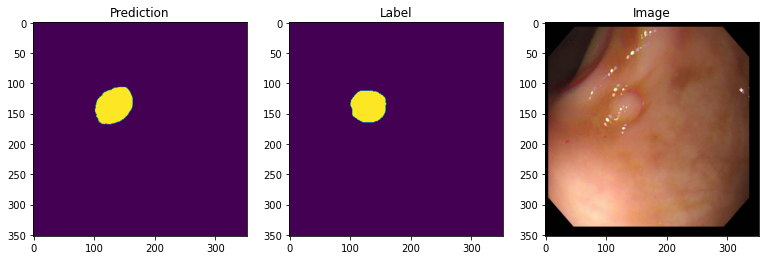

In [79]:
plt.figure(figsize=(13, 13))

plt.subplot(1, 3, 1)
plt.title("Prediction")
plt.imshow(prediction_test[0])

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(Y_test[0])

plt.subplot(1, 3, 3)
plt.title("Image")
plt.imshow(X_test[-9])

print(jaccard_score(np.ndarray.flatten(np.array(Y_test[-8], dtype=bool)), 
                    np.ndarray.flatten(prediction_test[-8] > 0.5)))

In [73]:
def calculate_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou_score = intersection / union
    return iou_score

In [81]:
def label_img(image_path, img_height=352, img_width=352):
    
    X_train = np.zeros((1, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((1, img_height, img_width), dtype=np.uint8)
    
    mask_path = image_path.replace("images", "labels")

    image = imread(image_path)
    mask_ = imread(mask_path)

    mask = np.zeros((img_height, img_width), dtype=np.bool_)

    pillow_image = Image.fromarray(image)

    pillow_image = pillow_image.resize((img_height, img_width))
    image = np.array(pillow_image)

    X_train = image / 255

    pillow_mask = Image.fromarray(mask_)
    pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
    mask_ = np.array(pillow_mask)

    for i in range(img_height):
        for j in range(img_width):
            if (mask_[i, j] >= 127).all():
                mask[i, j] = 1

    Y_train = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return np.expand_dims(X_train, axis=0), np.expand_dims(Y_train, axis=0)

In [82]:
a, aa = label_img('./Polyp_segmentation/test/images/9.bmp')

In [83]:
aa.shape

(1, 352, 352, 1)

0.9162361623616236


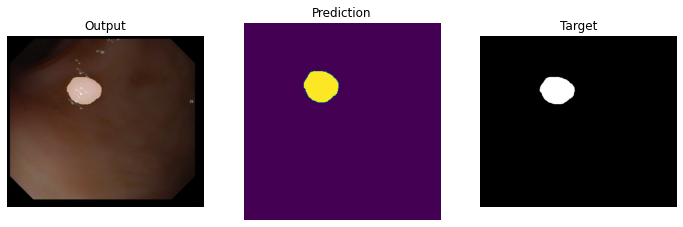

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
mask = np.squeeze((aa > 0.5).astype(np.uint8))

original = imread('./Polyp_segmentation/test/images/9.bmp')
original = Image.fromarray(original).convert('RGBA')
mask_img = Image.fromarray((mask * 255).astype(np.uint8)).convert('RGBA') # assuming the mask is a single channel image
mask_img = mask_img.resize((original.size[0], original.size[1]))
blended = Image.blend(original, mask_img, alpha=0.5)
axes[0].imshow(blended)
axes[0].set_title('Output')
axes[0].axis('off')

# ground truth mask
target = imread('./Polyp_segmentation/test/labels/9.bmp')
axes[2].imshow(target, cmap='gray')
axes[2].set_title('Target')
axes[2].axis('off')

# predicted mask
axes[1].imshow(mask)
axes[1].set_title('Prediction')
axes[1].axis('off')

print(calculate_iou(aa, ac>0.5))

In [88]:
ac = model.predict(a)
calculate_iou(aa, ac>0.5)

0.9162361623616236